In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Jasper Everink (DTU)
#  Edited by: Chao Zhang (DTU)
#  Reviewed by: Jakob Sauer Jørgensen (DTU)

# Implicit priors with regularized Gaussian distributions

### Jasper Everink (jmev@dtu.dk)
Regularization is frequently employed in variational inverse problems to enforce beliefs on the problem's parameters. In this notebook, we demonstrate how to use so-called implicit priors based on regularized Gaussian distributions from [[1]](https://iopscience.iop.org/article/10.1088/1361-6420/acf9c5) in CUQIpy.


In [2]:
# Load modules and set-up test problem
import sys
# sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

import cuqi
from cuqi.testproblem import Deconvolution1D
from cuqi.distribution import Gaussian, Gamma, JointDistribution
from cuqi.implicitprior import RegularizedGaussian, RegularizedGMRF
from cuqi.problem import BayesianProblem
from cuqi.sampler import RegularizedLinearRTO, Gibbs, Conjugate

from cuqi.solver import ProximalL1, ProjectNonnegative, ProjectBox

In [3]:
# Set seed
np.random.seed(42)

In [4]:
print("cuqi version: ", cuqi.__version__)

cuqi version:  0.8.0.post0.dev82


## Problem description

The problem under consideration is the 1D deconvolution problem, and it's already implemented in CUQIpy as a test problem `Deconvolution1D`. From this test problem, one can effortlessly extract essential components such as the forward operator, exact solution, and synthetic data. It's worth emphasizing that the techniques presented in this notebook extend beyond the confines of deconvolution problems; instead, they can be generally applied to any linear operator.

Text(0.5, 1.0, 'Data')

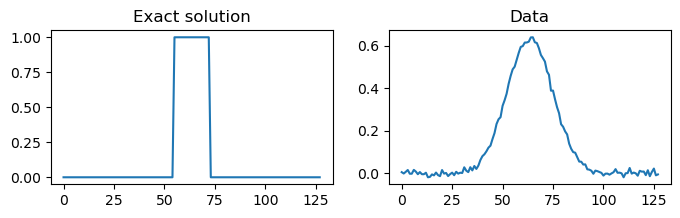

In [5]:
n = 128
A, y_data, info = Deconvolution1D(dim=n, phantom='square').get_components()

plt.figure(figsize = (8,2))
plt.subplot(1,2,1)
info.exactSolution.plot()
plt.title("Exact solution")

plt.subplot(1,2,2)
y_data.plot()
plt.title("Data")

## Implicit constraints and regularization

Let $A$ be a linear forward operator and consider the Gaussian likelihood function $L(y\,|\, x) \propto \exp\left(-\frac{1}{2}\|Ax-y\|^2_{\Sigma}\right)$ and Gaussian prior $\pi(x)\propto \exp\left(-\frac{1}{2}\|Lx-c\|^2_{\Lambda}\right)$.

The resulting posterior $\pi(x\,|\, y) \propto L(y\,|\, x)\pi(x) \propto \exp\left(-\frac{1}{2}\|Ax-y\|^2_{\Sigma} - \frac{1}{2}\|Lx-c\|^2_{\Lambda}\right)$ is a Gaussian distribution, from which can be sampled by solving the randomized linear least squares problem:

$
\min_{x \in \mathbb{R}^n} \left\{ \frac{1}{2}\|Ax-\hat{b}\|_\Sigma^2  + \frac{1}{2}\|Lx-\hat{c}\|_\Lambda^2\right\},
$

where $\hat{b}$ and $\hat{c}$ are random perturbations from $\text{Normal}(b, \Sigma^{-1})$ and $\text{Normal}(b, \Lambda^{-1})$ respectively.

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using direct sampling of Gaussian posterior. Only works for small-scale problems with dim<=2000.
No burn-in needed for direct sampling.
 Sample 1000 / 1000
Elapsed time: 0.16208720207214355
Plotting results


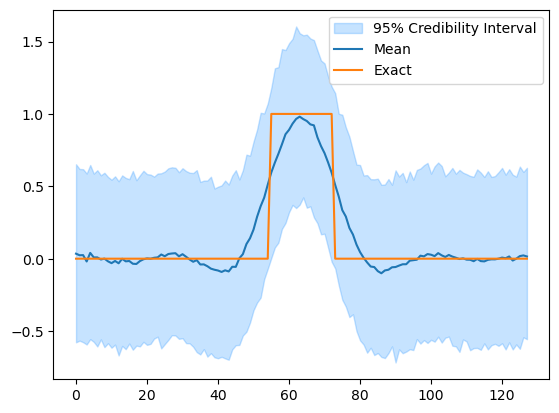

In [6]:
x  = Gaussian(np.zeros(n), 0.1)
y  = Gaussian(A@x, 0.001)
BP = BayesianProblem(y, x).set_data(y=y_data)
BP.UQ(exact=info.exactSolution)

Constraints and regularization can be added to randomized linear least squares problem by adding a suitable penalization function $R(x)$.
The resulting objective function from the regularized, randomized linear least squares problem can be split into two terms:

$
\min_{x \in \mathbb{R}^n} \left\{ \underbrace{\frac{1}{2}\|Ax-\hat{b}\|_\Sigma^2}_{\text{Gaussian likelihood}}  + \underbrace{\frac{1}{2}\|Lx-\hat{c}\|_\Lambda^2 + R(x)}_{\text{Regularized Gaussian implicit prior}}\right\}.
$

The Gaussian likelihood term is the same as in the unregularized problem, however, the prior term now consists of both a randomized linear least squares error term from the original Gaussian prior and the regularization term.
These two prior terms are combined into the `RegularizedGaussian` implicit prior as follows:

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Regularized LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 8.874834060668945
Plotting results


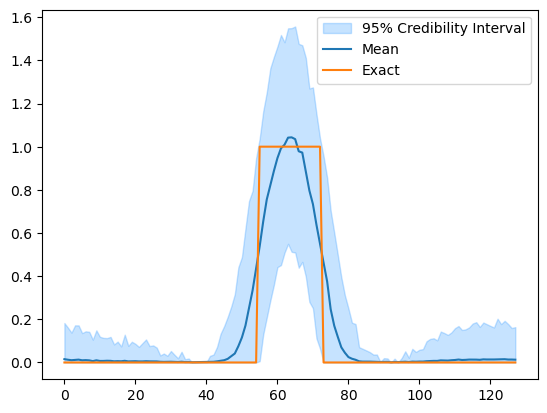

In [7]:
# Let R(x) be 0 if x is nonnegative and infinite otherwise, that is, R(x) represents a nonnegativity constraints
x  = RegularizedGaussian(0.5*np.ones(n), 0.1, constraint = "nonnegativity")
y  = Gaussian(A@x, 0.001)
BP = BayesianProblem(y, x).set_data(y=y_data)
BP.UQ(exact=info.exactSolution)

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Regularized LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 8.716900110244751
Plotting results


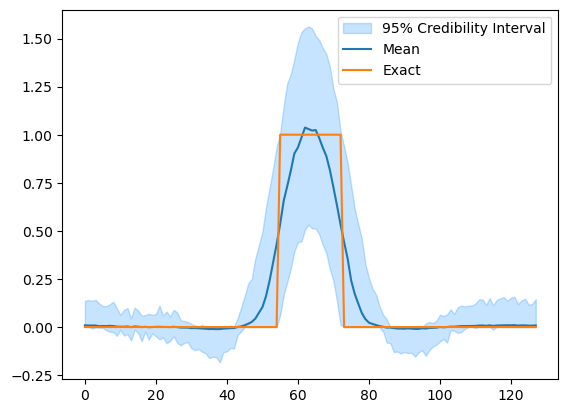

In [8]:
# Let R(x) = 6*||x||_1
x  = RegularizedGaussian(0.5*np.ones(n), 0.1, proximal = lambda z, s : ProximalL1(z, 6*s))
y  = Gaussian(A@x, 0.001)
BP = BayesianProblem(y, x).set_data(y=y_data)
BP.UQ(exact=info.exactSolution)

Note that these implicit priors are - as the name suggests - only defined implicitly and can only be sampled from after being combined with a likehood. Therefore, one cannot sample directly from the regularized Gaussian implicit prior itself, which can be seen by the following code causing an error:

In [9]:
x  = RegularizedGaussian(0.5*np.ones(n), 0.1, constraint = "nonnegativity")
_ = x.sample() # This line should raise an error, but don't worry, it's expected

ValueError: Cannot be sampled from.

## Creating a regularized Gaussian implicit prior

There are different ways of constructing Regularized Gaussian implicit priors:
- For certain pre-implemented constraints, one can specify the constraint a simple string like "nonnegativity" or "box".

- For general constraints on $C$, one can specify a projector function $\text{projector}(z) = \argmin_{x \in C} \left\{\|x-z\|_2\right\}$.

- For general regularization functions $R$, one has to specify the proximal operator $\text{prox}_R(z, s) = \argmin_{x \in \mathbb{R}^n} \left\{\|x-z\|^2_2 + s\ R(x)\right\}$.

Note that constraints cannot be supplied using an indicator function, due to the algorithm used for solving the regularized linear least squares problem.

The following code shows various ways of creating regularized Gaussian implicit priors.

In [10]:
# The following are equivalent*
# Nonnegativity constraint
x  = RegularizedGaussian(0.5*np.ones(n), 0.1, constraint = "nonnegativity")
x  = RegularizedGaussian(0.5*np.ones(n), 0.1, projector  = ProjectNonnegative)
x  = RegularizedGaussian(0.5*np.ones(n), 0.1, projector  = lambda z : np.maximum(z, 0))
x  = RegularizedGaussian(0.5*np.ones(n), 0.1, proximal   = lambda z, s : np.maximum(z, 0))
# * Those specified using the constraint argument can be used in some hierarchical models

# The following are equivalent
# Box ([0,1]^n) constraint
x  = RegularizedGaussian(0.5*np.ones(n), 0.1, constraint = "box")
x  = RegularizedGaussian(0.5*np.ones(n), 0.1, projector  = ProjectBox)
x  = RegularizedGaussian(0.5*np.ones(n), 0.1, projector  = lambda z : np.minimum(np.maximum(z, 0), 1))
x  = RegularizedGaussian(0.5*np.ones(n), 0.1, proximal   = lambda z, s : np.minimum(np.maximum(z, 0), 1))


# l1 (R(x) = \|x\|_1) regularization
x  = RegularizedGaussian(0.5*np.ones(n), 0.1, proximal   = ProximalL1)
# l1 (R(x) = gamma*\|x\|_1) regularization
gamma = 10
x  = RegularizedGaussian(0.5*np.ones(n), 0.1, proximal   = lambda z, s : ProximalL1(z, gamma*s))

Alongside the `RegularizedGaussian` implicit prior, there is also the `RegularizedGMRF` implicit prior, which is initialized in a similar manner, but with the `Gaussian` arguments replaced by arguments of `GMRF`.

In [11]:
x = RegularizedGMRF(np.zeros(n), lambda d:d, constraint = "nonnegativity")

## Regularized Linear RTO (Randomize-then-Optimize)
Once the implicit regularized Gaussian prior is combined with a Gaussian likelihood, samples can be obtained by solving the regularized, randomized linear least squares problem. This sampler is implemented as the `RegularizedLinearRTO` sampler, which uses the FISTA algorithm  from [[2]](https://epubs.siam.org/doi/abs/10.1137/080716542) to solve the regularized linear least squares problem. 

Sample 1100 / 1100


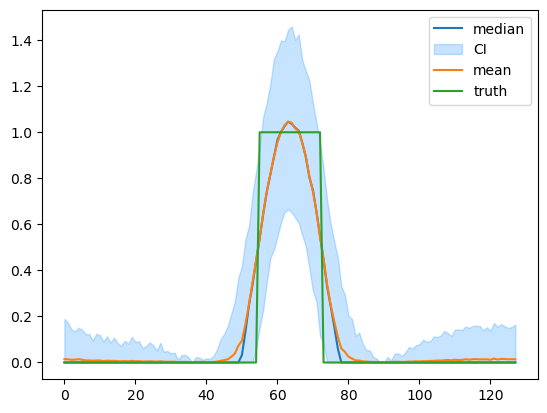

In [12]:
x  = RegularizedGaussian(0.5*np.ones(n), 0.1, constraint = "nonnegativity")
y  = Gaussian(A@x, 0.001)

joint = JointDistribution(x, y)
posterior = joint(y=y_data)

sampler = RegularizedLinearRTO(posterior,
                                maxit=100,       # Maximum number of iterations for underlying FISTA solver
                                stepsize = 5e-4, # Stepsize for underlying FISTA solver, or set to "automatic" to automatically select the stepsize
                                abstol=1e-10)    # Absolute error tolerance for stopping criteria of underlying FISTA solver
samples = sampler.sample(1000, 100)

plt.figure()
samples.plot_median() # Median is a more representative point-estimate for this distribution
samples.plot_ci()
plt.plot(info.exactSolution)
plt.legend(["median", "CI", "mean", "truth"])
plt.show()

## Nonnegative Hierarchical Gibbs sampler

In the nonnegativity constrainted setting, Gibbs samplers can still be derived for simple hierarchical models like:
$$
x\,|\, \lambda, \delta, b = \min_{x \in \mathbb{R}_{\geq 0}^{n}} \left\{\frac{\lambda}{2}\|Ax-\hat{b}\|_2^2 + \frac{\delta}{2}\|Lx-\hat{c}\|_2^2\right\},
$$
$$
\text{with } \hat{b} \sim \text{Normal}(b, \lambda^{-1}I) \text{ and } \hat{c} \sim \text{Normal}(0, \delta^{-1}I),
$$
$$
\lambda \sim \text{Gamma}(\alpha_{\lambda}, \beta_{\lambda}),
$$
$$
\delta \sim \text{Gamma}(\alpha_{\delta}, \beta_{\delta}).
$$

For a detailed derivation, see [[3]](https://epubs.siam.org/doi/abs/10.1137/18M1234588) or [[4]](https://epubs.siam.org/doi/full/10.1137/22M150695X)

To use this Gibbs sampler in CUQIpy, the constraint needs to be specified using `constraint = "nonnegativity"`, as in the following example:

Warmup 200 / 200
Sample 1000 / 1000


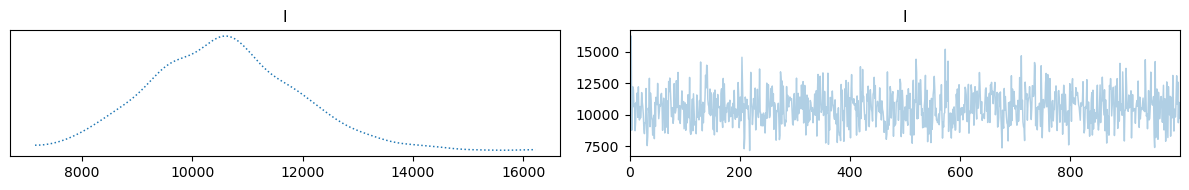

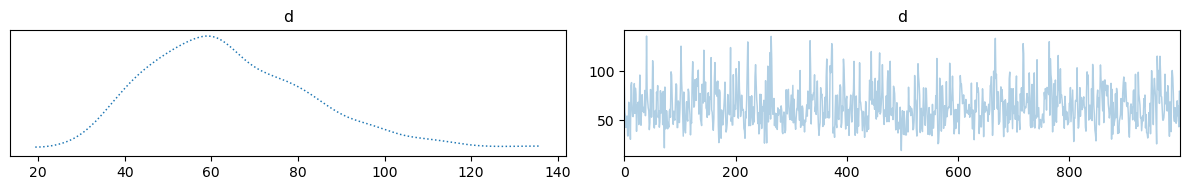

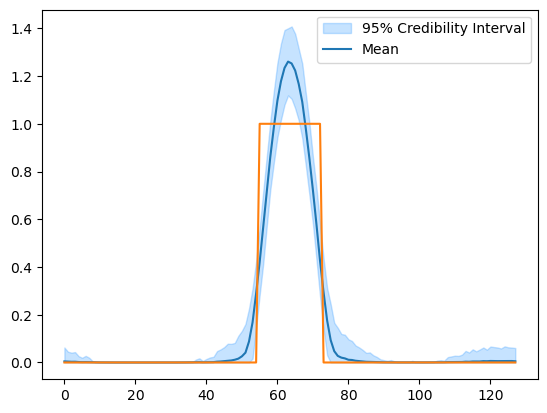

In [13]:
d = Gamma(1, 1e-4)
l = Gamma(1, 1e-4)
x = RegularizedGMRF(np.zeros(n), prec = lambda d:d, constraint = "nonnegativity")
y = Gaussian(A@x, prec = lambda l:l)

# Combine into a joint distribution
joint = JointDistribution(d, l, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'd': Conjugate,
    'l': Conjugate
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 200)

samples['l'].plot_trace()
samples['d'].plot_trace()
plt.figure()
samples['x'].plot_ci()
plt.plot(info.exactSolution)

## Future features
The following related features might be implemented in the future:
- More constraints, e.g., simplex, and regularization options, e.g., anisotropic total variation
- Multiple solvers
- Gibbs samplers for regularization of the form $R(x) = \gamma \|Lx\|_1$

## References
[1]: [Everink, J. M., Dong, Y., & Andersen, M. (2023). Sparse bayesian inference with regularized gaussian distributions. Inverse Problems.](https://iopscience.iop.org/article/10.1088/1361-6420/acf9c5)

[2]: [Beck, A., & Teboulle, M. (2009). A fast iterative shrinkage-thresholding algorithm for linear inverse problems. SIAM journal on imaging sciences, 2(1), 183-202.](https://epubs.siam.org/doi/abs/10.1137/080716542)

[3]: [Bardsley, J. M., & Hansen, P. C. (2020). MCMC algorithms for computational UQ of nonnegativity constrained linear inverse problems. SIAM Journal on Scientific Computing, 42(2), A1269-A1288.](https://epubs.siam.org/doi/abs/10.1137/18M1234588)

[4]: [Everink, J. M., Dong, Y., & Andersen, M. S. (2023). Bayesian inference with projected densities. SIAM/ASA Journal on Uncertainty Quantification, 11(3), 1025-1043.](https://epubs.siam.org/doi/full/10.1137/22M150695X)